In [11]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.optimize import brentq
%run functions_black_scholes_and_additional.py

import types
# List all functions in functions_black_scholes_and_additional.py
function_list = [name for name, obj in globals().items() if isinstance(obj, types.FunctionType)]
print(function_list[1:])

['__nonzero__', 'bs_call', 'bs_put', 'bs_call_delta', 'bs_put_delta', 'bs_gamma', 'bs_vega', 'bs_call_theta', 'bs_put_theta', 'bs_call_rho', 'bs_put_rho', 'MC_call_delta_custom', 'MC_call_delta_custom_array', 'MC_profits_hedged', 'implied_volatility_call', 'brentq']


In [22]:
def MC_profits_hedged(S0, t, r, mu, n_paths, n_steps, sigma, delta_sims):
    '''
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    sigma (vector): vector of random sigmas  
    Returns:
    np.array of simulated values of Black-Scholes value of call option
    This is a modified version of the function MC_call_custom_sigma
    Warning:
    This function is not a true simulation. The Black-Scholes equation for Delta is not simulated.
    '''

    paths = stock_path_custom_sigma_modified(S0, t, r, mu, n_paths, n_steps, sigma)
    
    path_ends = paths[:,-1] 

    dt = t/n_steps #time interval between each step in simulated path
 
    call_payoffs = np.maximum(path_ends - K, 0)*np.exp(-r*t)

    ## profit from start to first step discounted to time 0
    paths_first_step = paths[:,0]
    delta_start = MC_call_delta_custom(S0, K, sigma_array, sigma_probs, t, r, delta_sims)

    stock_profits_start = (paths_first_step - np.exp(r*dt)*S0)*delta_start*np.exp(-r*dt)

    total_stock_profits = []

    total_stock_profits.append(stock_profits_start)

    ## stock profits in intermediate steps
    for i in range(1,n_steps):
        path_starts = paths[:,i-1]
        path_ends = paths[:,i]
        #time to expiration from starting point 
        #needed to find delta of option and how much stock should be held to be delta neutral until next step
        tte = t - i*dt 
        deltas = MC_call_delta_custom_array(path_starts, K, sigma_array, sigma_probs, tte, r,delta_sims)
        stock_profit = (path_ends - path_starts*np.exp(r*dt))*deltas*np.exp(-r*(i+1)*dt)
        total_stock_profits.append(stock_profit)

    stock_profits = np.sum(total_stock_profits, axis = 0)

    profits_hedged = call_payoffs - stock_profits
    
    return profits_hedged

def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan

def stock_path_custom_sigma_modified(S0, t, r, mu, n_paths, n_steps, sigma):
    '''
    Generation of custom stock paths following Geometric Brownian motion,
    but log-returns do not have constant volatility.
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    sigma (vector): vector of random sigmas  
    Returns:
    
    Simulated stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
     
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at the start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)

    return paths

### Path simulation based on the Heston model

In [16]:
### Simulated stock paths under Heston model
kappa = 4
theta = .45**2
xi = .5
v0 = 0.4**2
rho = -0.05
S0 = 100
t = 1
n_steps = 252*2
r = 0.039
n_paths = 10
dt = t / n_steps
mu = .275

delta_sims = 100

dt = t / n_steps
N1 = np.random.normal(0, 1, size=(n_paths, n_steps))
N2 = np.random.normal(0, 1, size=(n_paths, n_steps))
Y = rho * N1 + np.sqrt(1 - rho**2) * N2

paths = np.zeros((n_paths, n_steps + 1))
vols = np.zeros((n_paths, n_steps + 1))
paths[:, 0] = S0
vols[:, 0] = v0

for i in range(n_steps):
    vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                            xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
    paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                           np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])

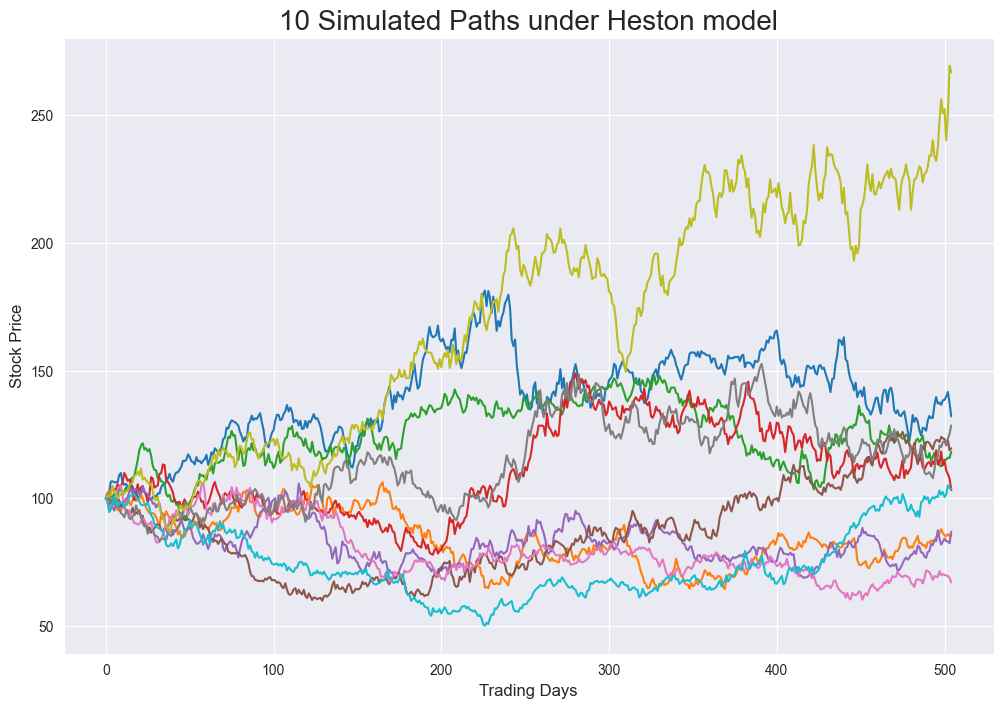

In [17]:

plt.figure(figsize = (12,8))

for path in paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths under Heston model', size = 20)
plt.xlabel('Trading Days', size = 12)
plt.ylabel('Stock Price', size = 12)

plt.show()

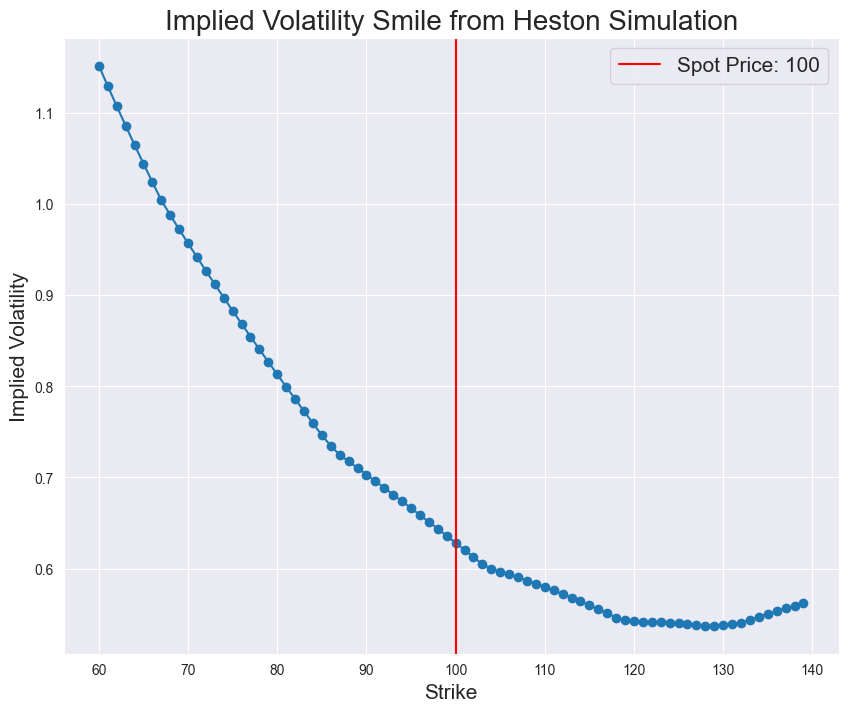

In [18]:
# Option pricing
strikes = range(int(.6*S0), int(1.4*S0))
S_t = paths[:, -1]
call_dict = {K: np.mean(np.maximum(S_t - K, 0)) * np.exp(-r * t) for K in strikes}

# Compute implied vols
implied_vol = {K: implied_volatility_call(call_dict[K], S0, K, t, r) for K in strikes}

# Plot
plt.figure(figsize = (10,8))
plt.plot(list(implied_vol.keys()), list(implied_vol.values()), marker='o')
plt.xlabel("Strike", size = 15)
plt.ylabel("Implied Volatility", size = 15)
plt.title("Implied Volatility Smile from Heston Simulation", size = 20)
plt.grid(True)
plt.axvline(S0, label= f'Spot Price: {S0}', color = 'red')

plt.legend(fontsize = 15)
plt.show()

Now I will proceed to compute Monte-Carlo simulation of the Black-Scholes value of a call option:

In [ ]:
path_ends = paths[:,-1] 
dt = t/n_steps #time interval between each step in simulated path

bump = .01*S0

noise = np.random.normal(0,1,delta_sims)

ps = [1/len(implied_vol.keys())]*len(implied_vol.keys())
index_K = np.random.choice(list(implied_vol.keys()), p=ps, size = delta_sims)

#sampled_sigma = np.random.choice(sigma,p=sigma_probs,size=delta_sims)
#sampled_sigma = implied_vol.values()

log_returns = (r - .5*sampled_sigma**2)*t + sampled_sigma*np.sqrt(t)*noise

paths_up = (S0+bump)*np.exp(log_returns)
paths_down = (S0-bump)*np.exp(log_returns)

call_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)
call_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

simulated_deltas = (call_up-call_down)/(2*bump)

call_payoffs = np.maximum(path_ends - K, 0)*np.exp(-r*t)


In [34]:
index = np.random.choice(list(implied_vol.keys()), p=ps, size = delta_sims)
index

array([113, 131, 133, 100, 126, 129,  85,  68, 127,  95, 127,  95, 135,
        63,  89, 133, 122, 113, 104,  97,  78,  71,  84,  89,  78,  86,
        71, 107,  89,  90, 122,  92, 133, 110,  71,  74,  63, 104, 123,
        78,  95, 116, 138,  95,  91, 101, 136,  88, 125, 119, 106,  90,
        94, 108,  90, 121,  91,  79, 134,  91, 119,  88,  85,  70, 131,
       115,  85, 123,  83, 124, 124, 134, 112,  61,  79, 123,  67, 121,
       133,  89, 113, 104,  66,  86,  93,  90,  92, 118, 135,  63,  61,
        76, 133,  79, 101,  95, 126,  77, 131,  81])

In [32]:
list(implied_vol.keys())

[60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139]

In [24]:
profits_hedged_heston = MC_profits_hedged(S0=S0, t=t, r=r, mu=mu, n_paths=n_paths, n_steps=n_steps, sigma=np.array(list(implied_vol.values())) , delta_sims=delta_sims)

ValueError: operands could not be broadcast together with shapes (80,) (10,504) 

{60: 1.1816051993756198,
 61: 1.1628416855503514,
 62: 1.1444300681857744,
 63: 1.1263535809646243,
 64: 1.1085964202958047,
 65: 1.0911436667632115,
 66: 1.073981213843456,
 67: 1.0570957030618748,
 68: 1.0404744648604334,
 69: 1.0276742324672252,
 70: 1.0151000920157096,
 71: 1.002657113093906,
 72: 0.9903392794719393,
 73: 0.9781408059178978,
 74: 0.9660561204862418,
 75: 0.9540798479222664,
 76: 0.9422067940636366,
 77: 0.9304319311280902,
 78: 0.9187503837815097,
 79: 0.9071574159069777,
 80: 0.8956484179666393,
 81: 0.8842188948886789,
 82: 0.8728644543946392,
 83: 0.8615807956924324,
 84: 0.850363698461568,
 85: 0.8392090120583909,
 86: 0.8281126448694519,
 87: 0.8170705537405073,
 88: 0.8060787334070193,
 89: 0.7951332058493155,
 90: 0.7842300094912082,
 91: 0.7733651881592142,
 92: 0.7625347797003023,
 93: 0.751734804172569,
 94: 0.7409612514815876,
 95: 0.7302100683472371,
 96: 0.7194771444577043,
 97: 0.7087582976518166,
 98: 0.6980492579473023,
 99: 0.6891673009261258,
 100